In [31]:
import re
import spacy
from nltk.corpus import stopwords
from unidecode import unidecode
import string

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [33]:
import nltk
import numpy as np
import pandas as pd
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# Chargement des modèles français et anglais
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")


In [35]:
# Stopwords combinés
stopwords_fr = set(stopwords.words("french"))
stopwords_en = set(stopwords.words("english"))
stopwords_combined = stopwords_fr.union(stopwords_en)

In [36]:
RISK_KEYWORDS = {
    'financial_distress': [
        'deficit', 'perte', 'endettement', 'liquidite', 'insolvabilite', 
        'faillite', 'restructuration', 'difficulte', 'crise', 'loss', 
        'debt', 'bankruptcy', 'liquidity', 'distress', 'default',
        'impairment', 'write-down', 'provision', 'deterioration',
        'decline', 'decrease', 'negative', 'shortfall'
    ],
    'operational_issues': [
        'retard', 'probleme', 'suspension', 'arret', 'fermeture',
        'reduction', 'licenciement', 'restructuration', 'delay',
        'problem', 'closure', 'layoff', 'downsizing', 'interruption',
        'shutdown', 'suspension', 'difficulties', 'issues'
    ],
    'regulatory_concerns': [
        'sanction', 'amende', 'violation', 'non-conformite',
        'penalite', 'enquete', 'penalty', 'fine', 'investigation',
        'compliance', 'violation', 'audit', 'litigation',
        'lawsuit', 'legal', 'court', 'dispute'
    ],
    'market_risks': [
        'volatilite', 'incertitude', 'risque', 'exposition',
        'volatility', 'uncertainty', 'risk', 'exposure',
        'fluctuation', 'instability', 'vulnerable'
    ]
}

In [44]:
# Flatten all risk keywords
from pathlib import Path

ALL_RISK_KEYWORDS = []
for category in RISK_KEYWORDS.values():
    ALL_RISK_KEYWORDS.extend(category)

def load_documents(data_path="data/extracted_texts"):
    """Load all text documents from the specified directory"""
    txt_files = list(Path(data_path).glob("*.txt"))
    
    documents = []
    file_names = []
    
    for file_path in txt_files:
        try:
            with open(file_path, encoding='utf-8', errors='ignore') as f:
                content = f.read()
                documents.append(content)
                file_names.append(file_path.name)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    print(f"Loaded {len(documents)} documents")
    return documents, file_names


In [46]:
def clean_text(text):
    # Normalisation : minuscules, sans accents
    text = text.lower()
    text = unidecode(text)
    
    # Suppression des caractères spéciaux
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove short words (less than 3 characters)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Suppression des mots trop courts
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\d+', ' NUM ', text)  # Replace numbers with token
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenisation + lemmatisation avec spaCy
    doc_fr = nlp_fr(text)
    doc_en = nlp_en(text)

    tokens = []
    for token in doc_fr:
        if token.lemma_ not in stopwords_combined:
            tokens.append(token.lemma_)
    for token in doc_en:
        if token.lemma_ not in stopwords_combined:
            tokens.append(token.lemma_)

    return " ".join(tokens)

In [47]:
def calculate_risk_score(text, risk_keywords=ALL_RISK_KEYWORDS):
    """Calculate risk score based on keyword presence"""
    text_lower = text.lower()
    risk_count = sum(1 for keyword in risk_keywords if keyword in text_lower)
    total_words = len(text_lower.split())
    
    if total_words == 0:
        return 0
    
    risk_score = (risk_count / total_words) * 100
    return risk_score

In [ ]:
def extract_risk_features(documents):
    """Extract various risk-related features from documents"""
    features = []
    
    for doc in documents:
        doc_features = {}
        
        # Basic statistics
        doc_features['doc_length'] = len(doc)
        doc_features['word_count'] = len(doc.split())
        
        # Risk keyword counts by category
        for category, keywords in RISK_KEYWORDS.items():
            count = sum(1 for keyword in keywords if keyword.lower() in doc.lower())
            doc_features[f'{category}_count'] = count
            doc_features[f'{category}_density'] = count / max(len(doc.split()), 1)
        
        # Overall risk score
        doc_features['total_risk_score'] = calculate_risk_score(doc)
        
        # Sentiment-related features (simple approach)
        negative_words = ['not', 'no', 'never', 'without', 'lack', 'failed', 'unable']
        doc_features['negative_sentiment'] = sum(1 for word in negative_words if word in doc.lower())
        
        features.append(doc_features)
    
    return pd.DataFrame(features)

## LOAD AND PREPROCESS DATA

In [49]:
# Load documents (using the path from your existing code)
try:
    documents, file_names = load_documents("data/extracted_texts/")
    if len(documents) == 0:
        # Fallback: use the document from your existing code
        documents = [" \n \n \n-1-\n \nParis, 13 April 2023 \n                                                                \n \n \n2022 full-year earnings \n \nResilience of current operating results in 2022, driven by international development \nand restructurings undertaken, despite a highly inflationary context and persistent supplies \navailability pressure \n \n  \n\uf0a7 \nEBITDA1 of €11.8m in 2022, down 7.5% from €12.6m in 2021, when EBITDA was boosted by a €3.1m \nnon-recurring credit note - Excluding this one-off item and incorporating the change in the EBITDA1 \ndefinition, EBITDA would have risen by  + 19 % \n \n\uf0a7 \nNet loss, Group share of €(0.9)m in 2022, compared to net profit, Group share of €5.6m in 2021, that \nwas boosted by €3.1m non-recurring income. 2022 includes an exceptional expense for the \nrestructuring of the Off-Trade sales department in France, announced early 2022. Restating these \ntwo exceptional items, 2022 net profit Group share would have been slightly lower than in 2021"]
        
        file_names = ['sample_financial_report.txt']
        print("sing sample document from your existing code")
        
        # Generate additional synthetic examples for demonstration
        synthetic_docs = [
            "Company reports strong growth with increased revenues and positive outlook for next quarter. Successful expansion in new markets.",
            "Significant losses reported due to market volatility. Restructuring costs impacted quarterly results. Liquidity concerns raised.",
            "Regulatory investigation launched following compliance violations. Potential penalties may affect future operations.",
            "Operational difficulties continue with production delays. Several facilities temporarily closed due to technical issues.",
            "Record profits achieved through strategic acquisitions. Strong balance sheet position maintained throughout the year."
        ]
        
        documents.extend(synthetic_docs)
        file_names.extend([f'synthetic_doc_{i+1}.txt' for i in range(len(synthetic_docs))])
        print(f"Added {len(synthetic_docs)} synthetic examples")
        
except Exception as e:
    print(f"Error loading documents: {e}")
    documents, file_names = [], []

print(f"Total documents to analyze: {len(documents)}")

# Clean documents
print("\nCleaning documents...")
cleaned_documents = [clean_text(doc) for doc in documents]
# Remove empty documents
valid_indices = [i for i, doc in enumerate(cleaned_documents) if len(doc.strip()) > 0]
documents = [documents[i] for i in valid_indices]
cleaned_documents = [cleaned_documents[i] for i in valid_indices]
file_names = [file_names[i] for i in valid_indices]

print(f"{len(documents)} valid documents after cleaning")


Loaded 100 documents
Total documents to analyze: 100

Cleaning documents...
99 valid documents after cleaning


## EXPLORATORY DATA ANALYSIS

In [ ]:
# Extract features
features_df = extract_risk_features(documents)
features_df['file_name'] = file_names


risk_threshold = features_df['total_risk_score'].quantile(0.6) 
features_df['is_risky'] = (features_df['total_risk_score'] > risk_threshold).astype(int)

print(f"Risk threshold: {risk_threshold:.2f}")
print(f"🔴 Risky documents: {features_df['is_risky'].sum()}")
print(f"🟢 Safe documents: {len(features_df) - features_df['is_risky'].sum()}")

Risk threshold: 0.22
🔴 Risky documents: 40
🟢 Safe documents: 59


In [51]:
features_df.head()

,doc_length,word_count,financial_distress_count,financial_distress_density,operational_issues_count,operational_issues_density,regulatory_concerns_count,regulatory_concerns_density,market_risks_count,market_risks_density,total_risk_score,negative_sentiment,file_name,is_risky
0,21440,3080,5,0.001623,4,0.001299,1,0.000325,2,0.000649,0.389610,3,FCMKW113796_20230413.txt,1
1,29770,4415,9,0.002039,1,0.000227,3,0.000680,2,0.000453,0.339751,2,FCMKW113833_20230413.txt,1
2,5213,753,0,0.000000,0,0.000000,1,0.001328,1,0.001328,0.265604,2,FCMKW113841_20230413.txt,1
3,7381,1086,1,0.000921,2,0.001842,0,0.000000,1,0.000921,0.368324,3,FCMKW113863_20230414.txt,1
4,2727,426,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0.000000,2,FCMKW113906_20230414.txt,0


In [85]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   doc_length                   99 non-null     int64  
 1   word_count                   99 non-null     int64  
 2   financial_distress_count     99 non-null     int64  
 3   financial_distress_density   99 non-null     float64
 4   operational_issues_count     99 non-null     int64  
 5   operational_issues_density   99 non-null     float64
 6   regulatory_concerns_count    99 non-null     int64  
 7   regulatory_concerns_density  99 non-null     float64
 8   market_risks_count           99 non-null     int64  
 9   market_risks_density         99 non-null     float64
 10  total_risk_score             99 non-null     float64
 11  negative_sentiment           99 non-null     int64  
 12  file_name                    99 non-null     object 
 13  is_risky              

In [52]:
# Display feature statistics
print("\n DOCUMENT STATISTICS")
print(features_df[['word_count', 'total_risk_score', 'financial_distress_count', 
                  'operational_issues_count', 'regulatory_concerns_count']].describe())




 DOCUMENT STATISTICS
        word_count  total_risk_score  financial_distress_count  \
count    99.000000         99.000000                 99.000000   
mean    759.484848          0.214594                  0.666667   
std     900.142533          0.245270                  1.428571   
min      68.000000          0.000000                  0.000000   
25%     259.000000          0.000000                  0.000000   
50%     425.000000          0.176367                  0.000000   
75%     942.000000          0.308654                  1.000000   
max    4790.000000          1.108033                  9.000000   

       operational_issues_count  regulatory_concerns_count  
count                 99.000000                  99.000000  
mean                   0.373737                   0.606061  
std                    0.802876                   0.842956  
min                    0.000000                   0.000000  
25%                    0.000000                   0.000000  
50%              

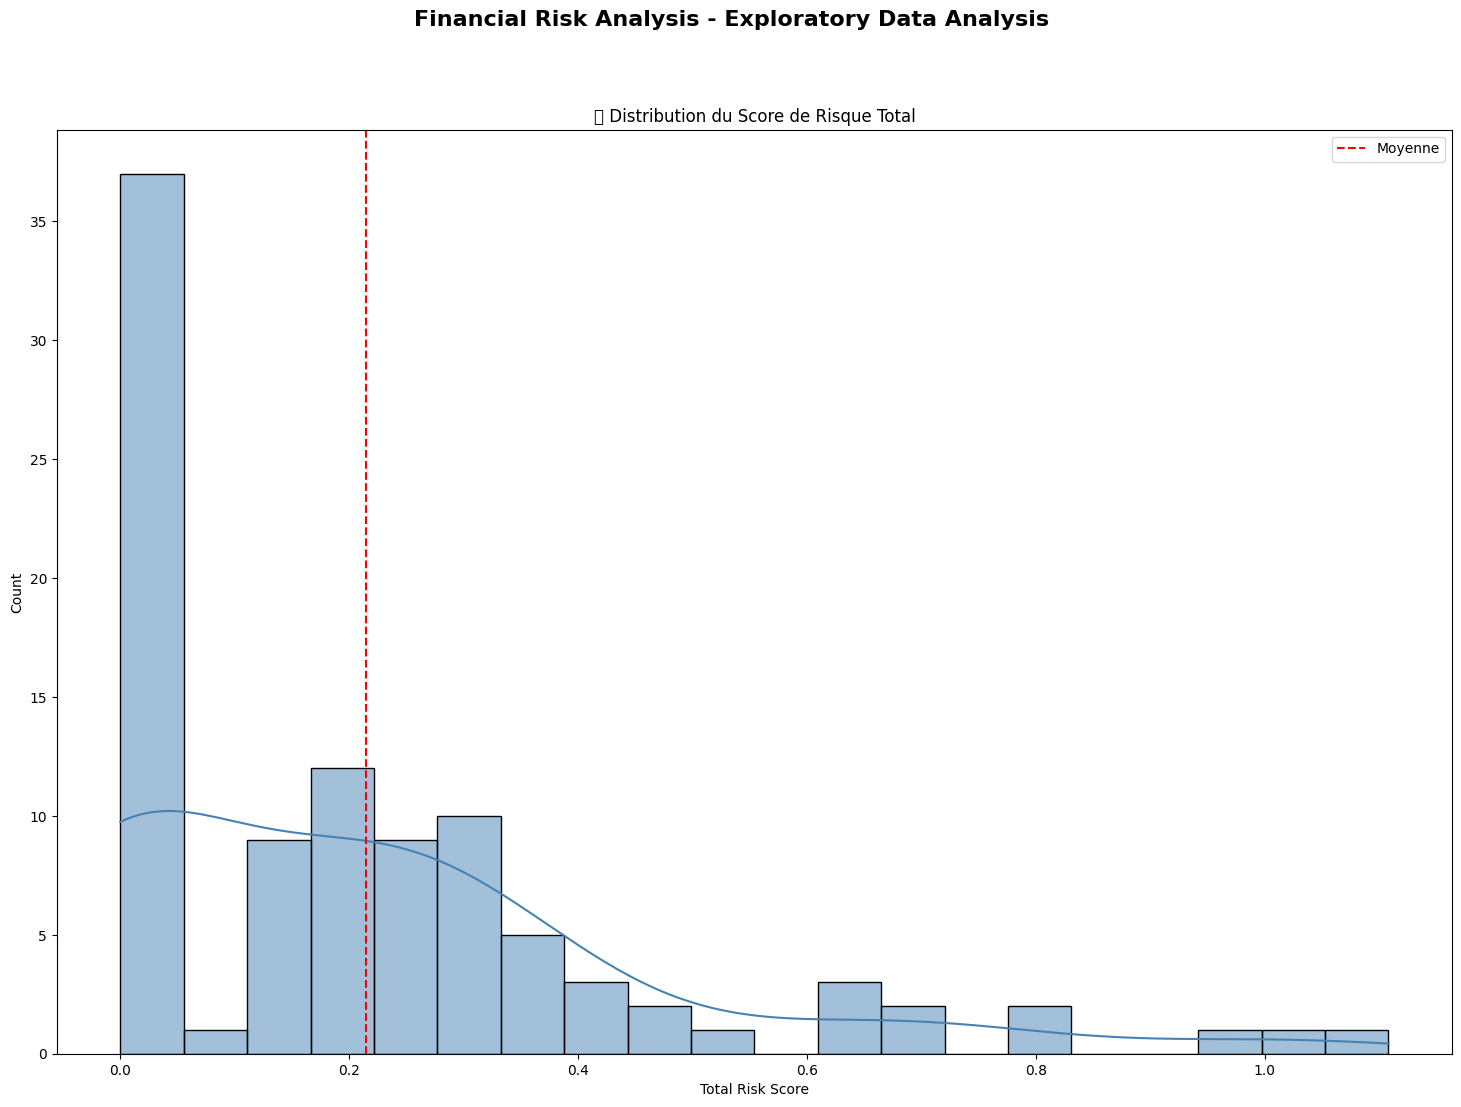

In [53]:
# Visualization setup
plt.style.use('default')
fig, axes = plt.subplots(1, 1, figsize=(18, 12))
fig.suptitle('Financial Risk Analysis - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Risk Score Distribution
sns.histplot(features_df['total_risk_score'], bins=20, kde=True, color='steelblue')
plt.title("📈 Distribution du Score de Risque Total")
plt.xlabel("Total Risk Score")
plt.axvline(features_df['total_risk_score'].mean(), color='red', linestyle='--', label='Moyenne')
plt.legend()
plt.show()

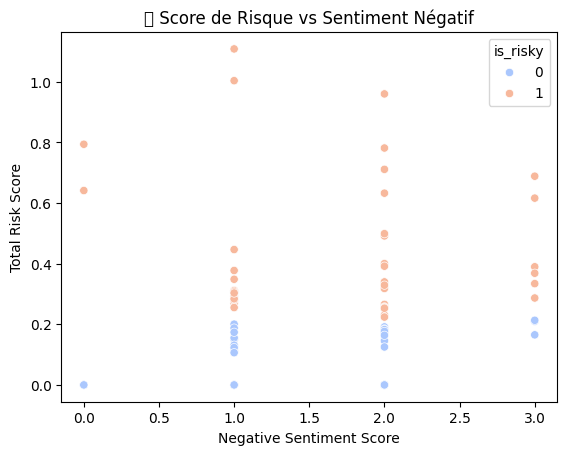

In [54]:
sns.scatterplot(x='negative_sentiment', y='total_risk_score', hue='is_risky', data=features_df, palette='coolwarm')
plt.title("📉 Score de Risque vs Sentiment Négatif")
plt.xlabel("Negative Sentiment Score")
plt.ylabel("Total Risk Score")
plt.show()

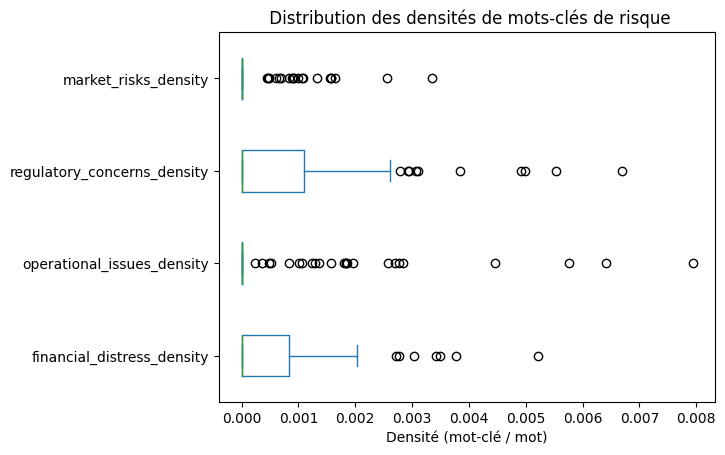

In [55]:
density_cols = ['financial_distress_density', 'operational_issues_density',
                 'regulatory_concerns_density', 'market_risks_density']
features_df[density_cols].plot(kind='box', vert=False, title=' Distribution des densités de mots-clés de risque')
plt.xlabel("Densité (mot-clé / mot)")
plt.show()

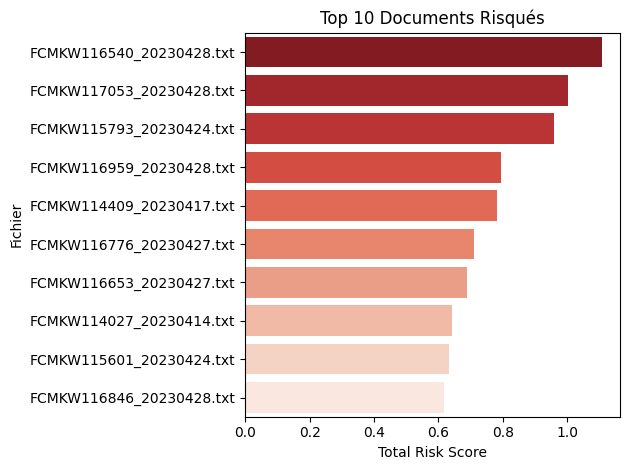

In [56]:
top_risk = features_df.sort_values(by='total_risk_score', ascending=False).head(10)
sns.barplot(y='file_name', x='total_risk_score', data=top_risk, palette='Reds_r')
plt.title("Top 10 Documents Risqués")
plt.xlabel("Total Risk Score")
plt.ylabel("Fichier")
plt.tight_layout()
plt.show()


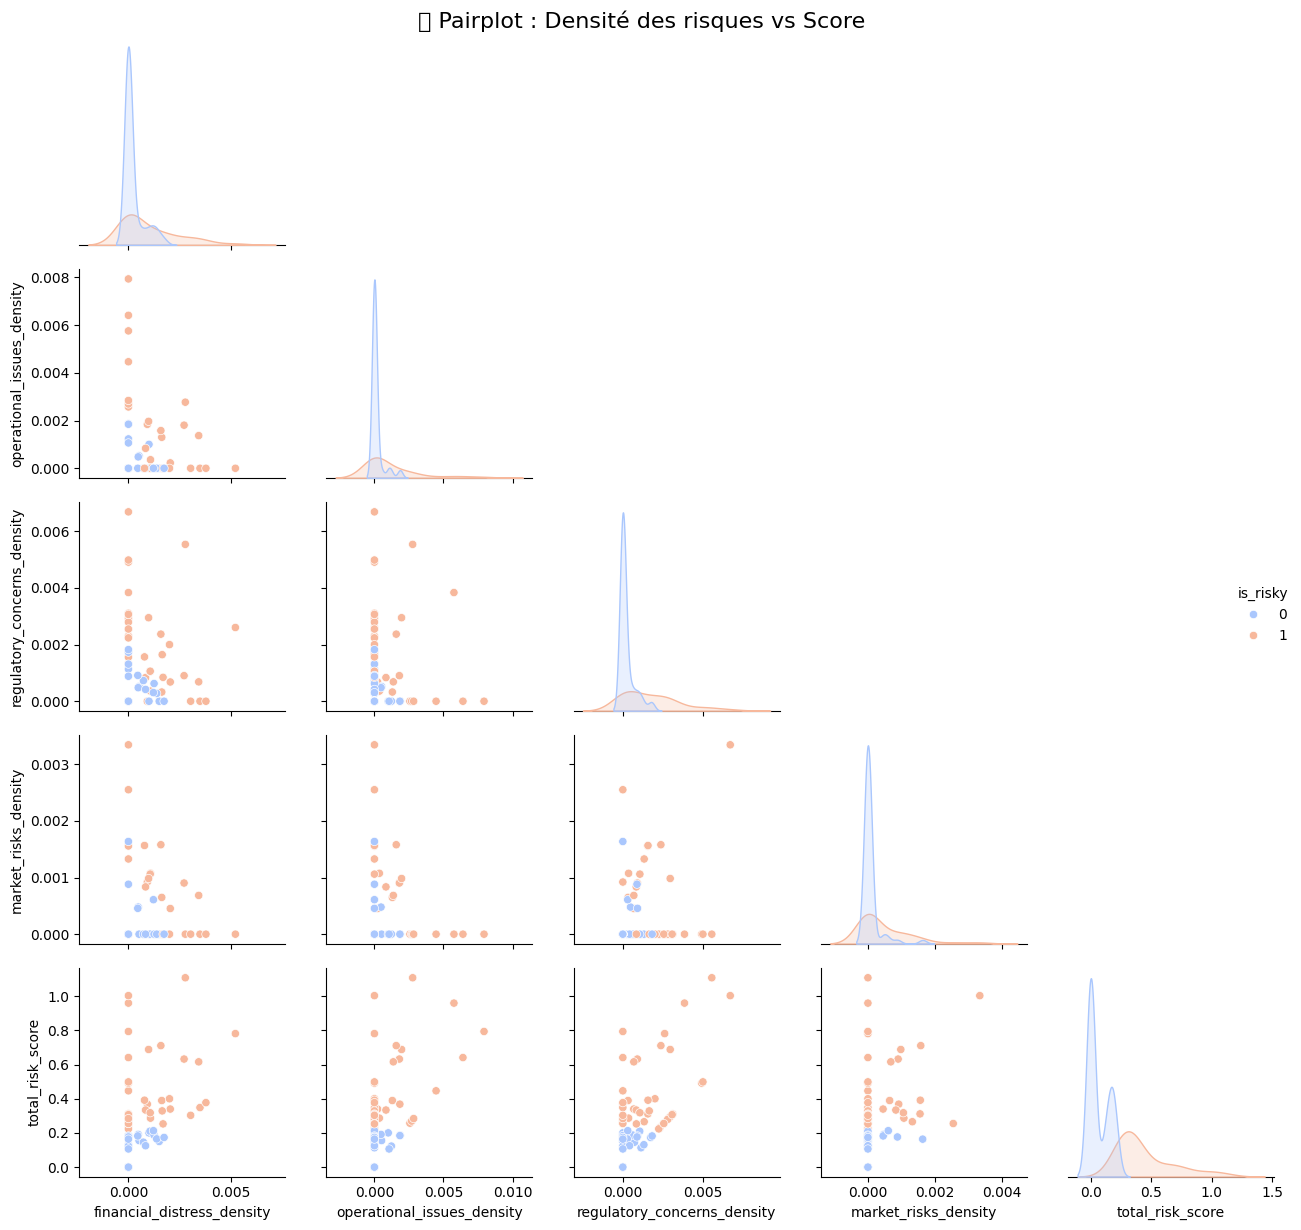

In [57]:
sns.pairplot(features_df, vars=density_cols + ['total_risk_score'], hue='is_risky', palette='coolwarm', corner=True)
plt.suptitle("🔍 Pairplot : Densité des risques vs Score", fontsize=16)
plt.tight_layout()
plt.show()



☁️ Generating Word Clouds...


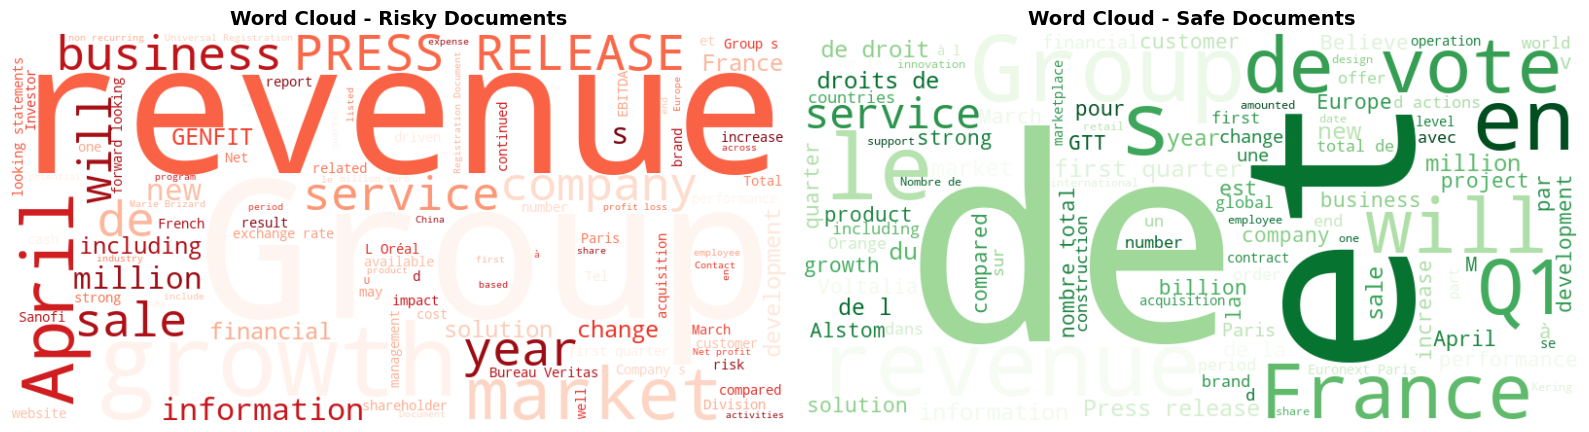

In [58]:
# Word Cloud for risky documents
print("\n☁️ Generating Word Clouds...")

# Combine all risky documents
risky_docs = [documents[i] for i in range(len(documents)) if features_df.iloc[i]['is_risky'] == 1]
safe_docs = [documents[i] for i in range(len(documents)) if features_df.iloc[i]['is_risky'] == 0]

if risky_docs:
    risky_text = ' '.join(risky_docs)
    
    # Create word clouds
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Risky documents word cloud
    wordcloud_risky = WordCloud(width=800, height=400, background_color='white', 
                               colormap='Reds', max_words=100).generate(risky_text)
    ax1.imshow(wordcloud_risky, interpolation='bilinear')
    ax1.set_title('Word Cloud - Risky Documents', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Safe documents word cloud
    if safe_docs:
        safe_text = ' '.join(safe_docs)
        wordcloud_safe = WordCloud(width=800, height=400, background_color='white', 
                                  colormap='Greens', max_words=100).generate(safe_text)
        ax2.imshow(wordcloud_safe, interpolation='bilinear')
        ax2.set_title('Word Cloud - Safe Documents', fontsize=14, fontweight='bold')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

## TEXT VECTORIZATION AND FEATURE ENGINEERING

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    min_df=1,  # Minimum document frequency
    max_df=0.95,  # Maximum document frequency
    stop_words=None  # We already cleaned stopwords
)

try:
    tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_documents)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create TF-IDF DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    
    X_combined = pd.concat([
        tfidf_df,
        features_df[['word_count', 'financial_distress_count', 'operational_issues_count', 
                    'regulatory_concerns_count', 'negative_sentiment']].reset_index(drop=True)
    ], axis=1)
    
    y = features_df['is_risky'].values
    
    print(f"Final feature matrix shape: {X_combined.shape}")
    print(f"Target distribution: {np.bincount(y)}")
    
except Exception as e:
    print(f"Error in vectorization: {e}")
    # Fallback to basic features only
    X_combined = features_df[['word_count', 'total_risk_score', 'financial_distress_count', 
                             'operational_issues_count', 'regulatory_concerns_count']].fillna(0)
    y = features_df['is_risky'].values

TF-IDF matrix shape: (99, 1000)
Final feature matrix shape: (99, 1005)
Target distribution: [59 40]


In [89]:
features_df[['word_count', 'financial_distress_count', 'operational_issues_count', 
                    'regulatory_concerns_count', 'negative_sentiment']]

,word_count,financial_distress_count,operational_issues_count,regulatory_concerns_count,negative_sentiment
0,3080,5,4,1,3
1,4415,9,1,3,2
2,753,0,0,1,2
3,1086,1,2,0,3
4,426,0,0,0,2
...,...,...,...,...,...
94,611,0,0,0,2
95,114,0,0,0,1
96,130,0,0,0,1
97,311,0,0,0,1


## MODEL

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


In [61]:
# Split data (if we have enough samples)
if len(X_combined) > 4:
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
else:
    # Use all data for training and testing (small dataset)
    X_train = X_test = X_combined
    y_train = y_test = y
    print("Small dataset: Using all data for training and testing")


Training set: (69, 1005), Test set: (30, 1005)


##  MODEL COMPARISON AND RESULTS

In [83]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import os
import joblib

In [66]:
def read_text_from_file(file_name, base_path="data/extracted_texts"):
    full_path = os.path.join(base_path, file_name)
    try:
        with open(full_path, "r", encoding="utf-8") as f:
            return f.read()
    except Exception as e:
        print(f"Erreur lecture fichier {file_name}: {e}")
        return ""

In [67]:
#  Lire le texte nettoyé à partir des fichiers
print("Lecture des fichiers texte...")
features_df["clean_text"] = features_df["file_name"].apply(read_text_from_file)

Lecture des fichiers texte...


In [ ]:
texts = features_df["clean_text"].fillna("")
y = features_df["is_risky"]
texts

0      \n \n \n-1-\n \nParis, 13 April 2023 \n      ...
1     PRESS RELEASE \n \n \n \nGENFIT | 885 Avenue E...
2      \n1 on 3 \n \nPRESS RELEASE \n \n \n \n \n \n...
3      \n \n \n \n \nwww.nicox.com \n \nPress Releas...
4      \n \n \nPress release \nParis, 14 April 2023 ...
                            ...                        
94     \nC O M M U N I Q U É  R É G L E M E N T É  \...
95     \n \n \nLUMIBIRD - 2 rue Paul Sabatier 22300 ...
96     \n \n \nDECLARATION MENSUELLE RELATIVE AU NOM...
97     \n \n \n \n \nCommuniqué                     ...
98     \n \n \n \n \nDANONE \n \n \n \nSociété anony...
Name: clean_text, Length: 99, dtype: object

In [69]:
# Embeddings BERT
print("Génération des embeddings BERT...")
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = bert_model.encode(texts.tolist(), show_progress_bar=True)

Génération des embeddings BERT...


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y, test_size=0.3, random_state=42, stratify=y
)

In [71]:
#Modèles simples
models = {
    #'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    #'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    #'Naive Bayes': GaussianNB()
}

In [72]:
#Entraînement & Évaluation
results_bert = {}

for name, model in models.items():
    print(f"\n Entraînement de {name}...")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    results_bert[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'model': model,
        'predictions': y_pred,
        'probabilities': y_proba
    }


 Entraînement de SVM...


In [73]:
# Résultats
results_df_bert = pd.DataFrame({
    name: [
        metrics['accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1_score']
    ] for name, metrics in results_bert.items()
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n PERFORMANCE METRICS (BERT + modèles simples)")
print(results_df_bert.round(3))


 PERFORMANCE METRICS (BERT + modèles simples)
             SVM
Accuracy   0.767
Precision  0.778
Recall     0.583
F1-Score   0.667


In [74]:
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [ ]:


# Sauvegarde du modèle SVM
joblib.dump(svm_model, "svm_model.pkl")
print("Modèle SVM sauvegardé sous 'svm_model.pkl'")


Modèle SVM sauvegardé sous 'svm_model.pkl'


In [76]:
# Sauvegarde du modèle BERT (SentenceTransformer)
bert_model.save("bert_encoder")
print("Modèle BERT sauvegardé dans le dossier 'bert_encoder/'")


Modèle BERT sauvegardé dans le dossier 'bert_encoder/'


In [77]:
tfidf_vectorizer_path = "tfidf_vectorizer.pkl"
joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)

['tfidf_vectorizer.pkl']

In [ ]:

joblib.dump(X_combined.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']